# Question to Answer: How much has Canada's Exports in Mineral Products Grown since 2021 and what are future projections?

## Set-up

In [ ]:
# Here we will call the setup.sh file which will set up and activate a venv
# The contents of the script file is below dont worry its not a virus
# if you are running a linux/unix machine, you will need to go into the .sh file and change 
# venv/scripts/ -> venv/bin/
# you may need to change the running environment in vscode to the newly created venv.
# you may also need to set the command to python3 rather than python. 

# ********************* IMPORTANT READ **********************
# also ensure the jupyter kernel (top right) is set to the venv kernel and that the interpreter is also set to python inside the venv
# after this cell runs otherwise there will be dependency issues
# ensure to restart language server on vscode as well

'''
python -m venv venv
call venv/scripts/activate
call pip install --upgrade pip
call pip install -r requirements.txt
'''
!setup.bat

In [1]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import pypyodbc as odbc
from IPython.display import display # allows display of pandas df as a table
import os

In [2]:
# Settings
plt.style.use('fivethirtyeight') # style of plots
pd.set_option('display.max_columns', 500) # sets max viewable cols to 500 in a df if the df is really wide
conn = odbc.connect(os.getenv('connectionString'))

cursor = conn.cursor()
table_name = "canada_export_data"

In [3]:
from pullData import load_data_from_api
load_data_from_api(table_name=table_name, conn=conn)

WE HAVE A KEY
Fetched:  68  records for period:  202201  cmdCode:  27
Fetched:  31  records for period:  202201  cmdCode:  26
Fetched:  50  records for period:  202201  cmdCode:  25
Fetched:  67  records for period:  202202  cmdCode:  27
Fetched:  23  records for period:  202202  cmdCode:  26
Fetched:  46  records for period:  202202  cmdCode:  25
Fetched:  74  records for period:  202203  cmdCode:  27
Fetched:  30  records for period:  202203  cmdCode:  26
Fetched:  55  records for period:  202203  cmdCode:  25
Fetched:  70  records for period:  202204  cmdCode:  27
Fetched:  29  records for period:  202204  cmdCode:  26
Fetched:  52  records for period:  202204  cmdCode:  25
Fetched:  78  records for period:  202205  cmdCode:  27
Fetched:  31  records for period:  202205  cmdCode:  26
Fetched:  52  records for period:  202205  cmdCode:  25
Fetched:  69  records for period:  202206  cmdCode:  27
Fetched:  34  records for period:  202206  cmdCode:  26
Fetched:  62  records for period: 

In [10]:
query = 'SELECT * FROM canada_export_data'

df = pd.read_sql_query(query, conn)

print(df.columns.tolist())


C:\Users\vansh\AppData\Local\Temp\ipykernel_13596\3528114311.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


['typecode', 'freqcode', 'refperiodid', 'refyear', 'refmonth', 'period', 'reportercode', 'reporteriso', 'reporterdesc', 'flowcode', 'flowdesc', 'partnercode', 'partneriso', 'partnerdesc', 'partner2code', 'partner2iso', 'partner2desc', 'classificationcode', 'classificationsearchcode', 'isoriginalclassification', 'cmdcode', 'cmddesc', 'aggrlevel', 'isleaf', 'customscode', 'customsdesc', 'moscode', 'motcode', 'motdesc', 'qtyunitcode', 'qtyunitabbr', 'qty', 'isqtyestimated', 'altqtyunitcode', 'altqtyunitabbr', 'altqty', 'isaltqtyestimated', 'netwgt', 'isnetwgtestimated', 'grosswgt', 'isgrosswgtestimated', 'cifvalue', 'fobvalue', 'primaryvalue', 'legacyestimationflag', 'isreported', 'isaggregate', 'pk']


In [11]:
# data cleaning
# we do not need cols like flowCode, classificationSearchCode, isOriginalClassification, isLeaf, customsCode, customsDesc, mosCode, motCode, motDesc, isReported, isAggregate, cifvalue
clean_df = df.drop(['flowcode', 'flowdesc', 'partner2code', 'partner2iso', 'partner2desc', 'classificationsearchcode', 'isoriginalclassification', 'isleaf', 'customscode', 'customsdesc', 'moscode', 'motcode', 'motdesc', 'isreported', 'isaggregate', 'cifvalue', 'legacyestimationflag'], axis=1)


In [14]:
# let's do some data cleaning and tranformation
# we will convert the date column to datetime for clean plotting
transform_df = clean_df.copy()
transform_df['date'] = pd.to_datetime(clean_df['period'], format='%Y%m').dt.to_period('M') # by default the to_datetime will return yyyy-mm-dd, so we add the .dt.to_period for just YYYY-MM

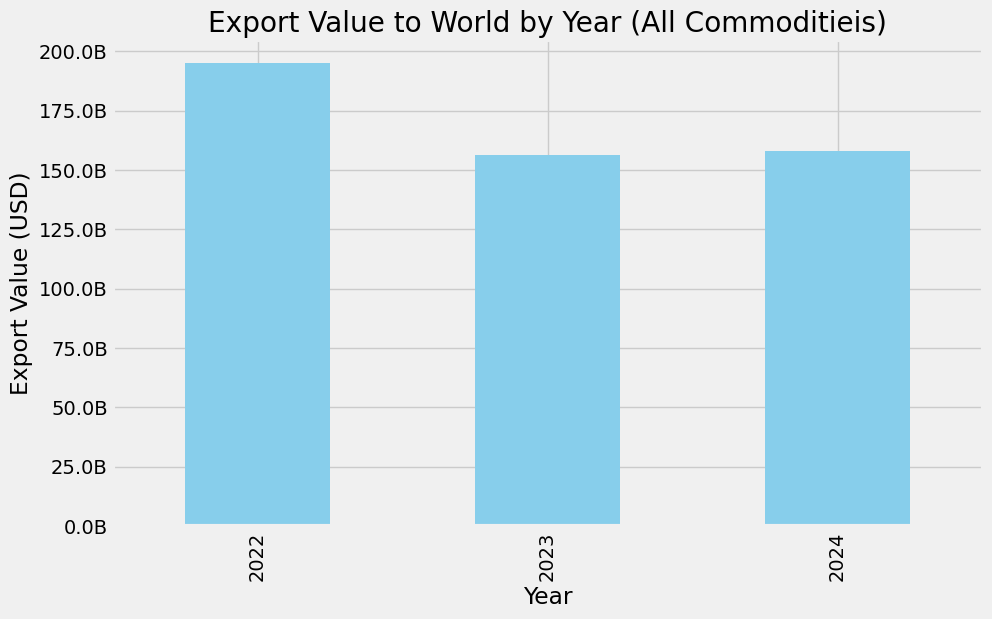

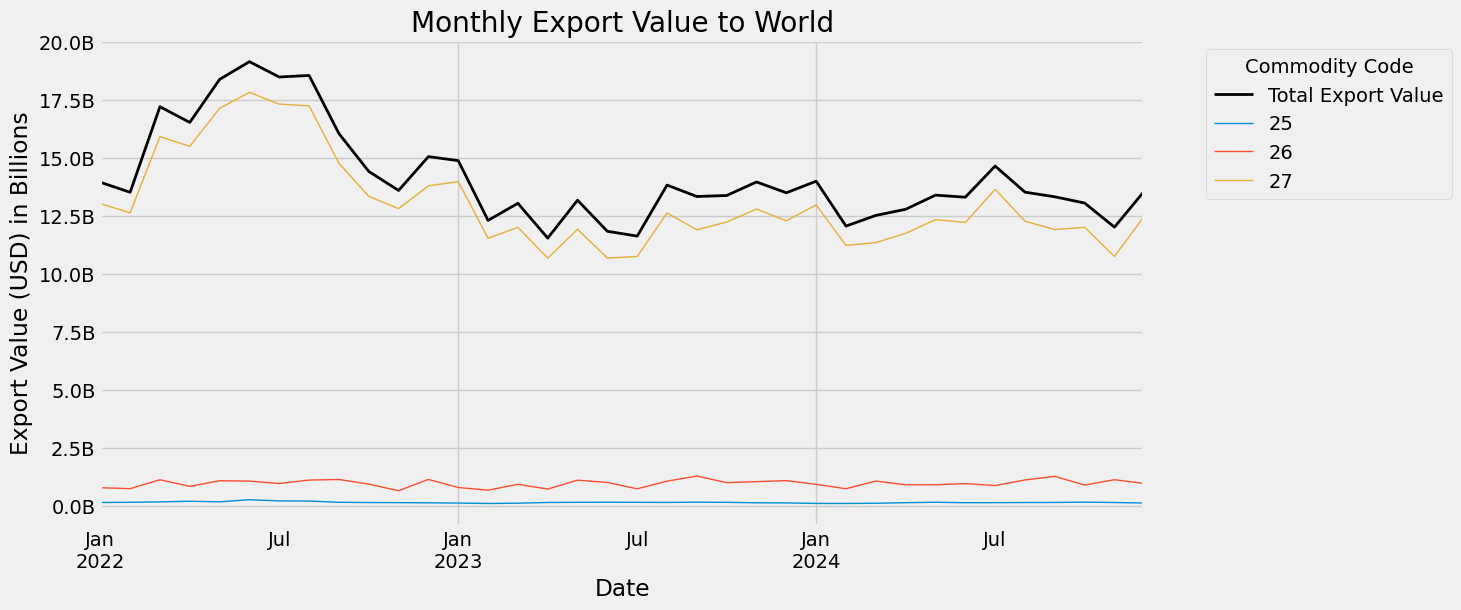

In [15]:
# let's do some plotting
# when partner or ISO value is World or WS00 -> that means the world total for the month
# let's also plot the trend data for each month to see the trend of exports to the world for minerals and mineral products
# here we calculate the total export value for all commodities to the world for each year in our data and plot it
import matplotlib.ticker as ticker # we use this to set the y axis scale in billions

yearly_sums = transform_df[transform_df['partneriso'] == 'W00' ].groupby('refyear')['primaryvalue'].sum()
monthly_sums = transform_df[transform_df['partneriso'] == 'W00'].groupby('date')['primaryvalue'].sum()
monthly_sums_per_commodity = transform_df[transform_df['partneriso'] == 'W00'].groupby(by=['date', 'cmdcode'])['primaryvalue'].sum().unstack()

# first let's plot the yearly export totals
plot = yearly_sums.plot(kind='bar', figsize=(10, 6), color='skyblue')
plot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-9:.1f}B'))
plt.title('Export Value to World by Year (All Commoditieis)')
plt.xlabel('Year')
plt.ylabel('Export Value (USD)')
plt.show()

# we create a single plot to show all the data -> one line per commodity, one line for the total
fig, ax = plt.subplots(figsize=(12, 6))
# now let's plot the monthly exports per commodity and the totals
monthly_sums.plot(ax=ax, color='black', linewidth=2, label='Total Export Value')
monthly_sums_per_commodity.plot(ax=ax, linewidth=1, legend=True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-9:.1f}B'))
ax.set_title('Monthly Export Value to World')
ax.set_xlabel('Date')
ax.set_ylabel('Export Value (USD) in Billions')
ax.legend(title='Commodity Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Number of countries: 169


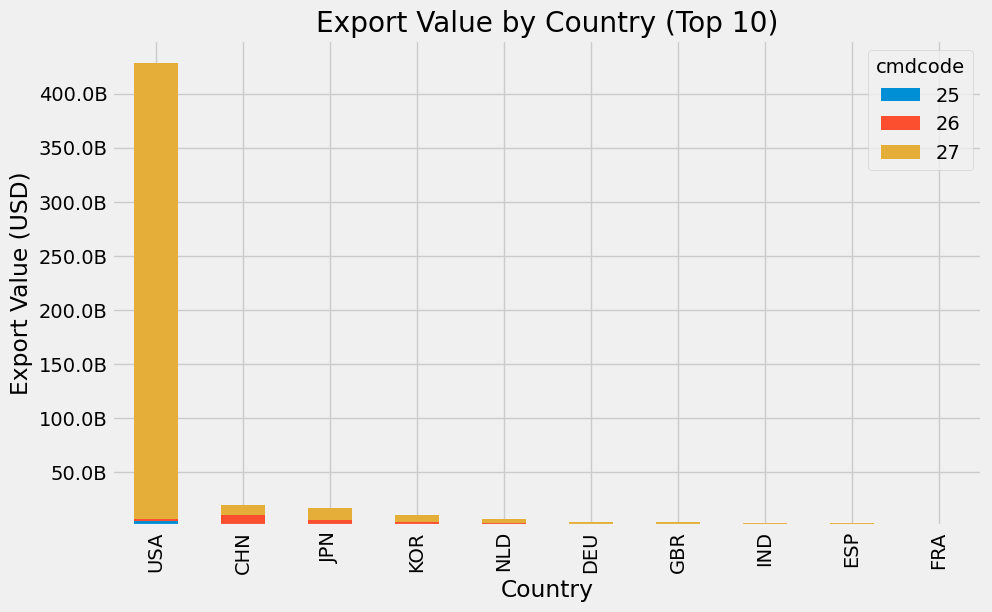

In [16]:
# Let's plot the exports for each partner country

numCountries = len(transform_df['partneriso'].unique())
print(f"Number of countries: {numCountries}")

countriesExports = transform_df[transform_df['partneriso'] != 'W00'].groupby(['partneriso', 'cmdcode'])['primaryvalue'].sum()

countriesExports = countriesExports.unstack().fillna(0)
countriesExports['TotalExports'] = countriesExports['27'].add(countriesExports['26']).add(countriesExports['25'])
countriesExports = countriesExports.sort_values('TotalExports', ascending=False)[:10]

ax = countriesExports.iloc[:, :3].plot(kind='bar', figsize=(10, 6), stacked=True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-9:.1f}B'))
plt.title('Export Value by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Export Value (USD)')
plt.show()